## Datasets Evaluation with Modified KNN

In [1]:
from reference_knn import KNNModifiedClassifier as KNNReferenceClassifier
from modified_knn import KNNModifiedClassifier 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
def k_fold_cross_validation(X, y, model, n_test: int = 10, metric=None) -> float:
    kf = KFold(n_splits=n_test)
    accuracies = []
    roc_auc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        if metric == 'roc_auc_ovr':
            roc_auc.append(roc_auc_score(y_test, y_pred, multi_class='ovo'))
        else: roc_auc.append(roc_auc_score(y_test, y_pred))
    return np.mean(accuracies), np.mean(roc_auc)


def k_fold_cross_validation_stratified(X, y, model, n_test: int = 15) -> float:
    skf = StratifiedKFold(n_splits=n_test)
    accuracies = []
    roc_auc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_pred))
    return np.mean(accuracies), np.mean(roc_auc)

# def plot_confusion_matrix(y_true, y_pred, ax, labels=None, cmap="Blues"):
#     cm = confusion_matrix(y_true, y_pred, labels=labels)
#     sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
#     ax.set_title("Confusion Matrix")
#     ax.set_xlabel("Predicted Labels")
#     ax.set_ylabel("True Labels")
#     fig, axes = plt.subplots(1, 3, figsize=(15, 4))

Evaluated 3 different KNN models:
- sk_knn -> Scikit learn KNN
- reference_knn -> KNN reference for the modified (https://github.com/rushter/MLAlgorithms/blob/master/mla/knn.py)
- modified_knn -> Modified KNN with the new hyperparameter weights='correlations'

In the CC18 analysis, we observed that using weights='distance' led to higher classification success. Based on this finding, the comparison with other models will also use weights='distance'

In [3]:
sk_knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
reference_knn = KNNReferenceClassifier(k=7, weight='distance')
modified_knn = KNNModifiedClassifier(k=7, weight='correlations')

## Evaluation of worsts classified datasets using Modified KNN

### Evaluation do Dataset 9971

In [4]:
df = pd.read_csv('../files_csv/csv_tests/dataset_9971.csv')
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500.0,20.0,34.0,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98.0,35.0,31.0,6.0,3.2,1.10,1
580,52,Male,0.8,0.2,245.0,48.0,49.0,6.4,3.2,1.00,1
581,31,Male,1.3,0.5,184.0,29.0,32.0,6.8,3.4,1.00,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      583 non-null    int64  
 1   V2      583 non-null    object 
 2   V3      583 non-null    float64
 3   V4      583 non-null    float64
 4   V5      583 non-null    float64
 5   V6      583 non-null    float64
 6   V7      583 non-null    float64
 7   V8      583 non-null    float64
 8   V9      583 non-null    float64
 9   V10     583 non-null    float64
 10  Class   583 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 50.2+ KB


In [25]:
categorical_columns = [column for column in df.columns if df[column].dtype == object]

for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column)  
    df = pd.concat([df, dummies], axis=1)  

df.drop(columns=categorical_columns, inplace=True)
df

,V1,V3,V4,V5,V6,V7,V8,V9,V10,Class,V2_Female,V2_Male
0,65,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1,True,False
1,62,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1,False,True
2,62,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1,False,True
3,58,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1,False,True
4,72,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,0.5,0.1,500.0,20.0,34.0,5.9,1.6,0.37,2,False,True
579,40,0.6,0.1,98.0,35.0,31.0,6.0,3.2,1.10,1,False,True
580,52,0.8,0.2,245.0,48.0,49.0,6.4,3.2,1.00,1,False,True
581,31,1.3,0.5,184.0,29.0,32.0,6.8,3.4,1.00,1,False,True


In [26]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

In [27]:
print(X.shape)
print(y.shape)

(583, 11)
(583,)


In [28]:
y.value_counts()

V2_Male
True     441
False    142
Name: count, dtype: int64

In [29]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 5)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 5)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 5)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7306660772178015
Mean ROC AUC Sklearn: 0.5488681524515997

Mean Accuracy Reference: 0.7117595048629531
Mean ROC AUC Reference: 0.5416821736040585

Mean Accuracy Modified: 0.7820660182729149
Mean ROC AUC Modified: 0.632148183027992


In [30]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 10)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 10)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 10)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7271186440677966
Mean ROC AUC Sklearn: 0.5565271852796914

Mean Accuracy Reference: 0.7184395090590299
Mean ROC AUC Reference: 0.5582518038424515

Mean Accuracy Modified: 0.7975745178258328
Mean ROC AUC Modified: 0.6526079246638891


In [31]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 15)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 15)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 15)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7274403958614485
Mean ROC AUC Sklearn: 0.5459806356474438

Mean Accuracy Reference: 0.7239766081871345
Mean ROC AUC Reference: 0.5462342042466006

Mean Accuracy Modified: 0.8112910481331533
Mean ROC AUC Modified: 0.6525024346055754


### Conclusions:
The 9971 dataset is a disbalance dataaset, and our modified KNN reach approximately 10% more roc_auc, using 10 and 15 folds of testing and reach approximately 7% more accuracy using 10 folds, and almost 10% more accuracy using 15 folds of testing. Using 5 folds of testing, our modified knn reached approximately the same evaluation as sk_learn. Its expected that with the lowest number of folds, the number of training samples will decrease, which may result in poorer model training and an increase in test samples that the model has not previously encountered.

### Evaluation do Dataset 10101

In [32]:
df = pd.read_csv('../files_csv/csv_tests/dataset_10101.csv')
df

,V1,V2,V3,V4,Class
0,2,50,12500.0,98,2
1,0,13,3250.0,28,2
2,1,16,4000.0,35,2
3,2,20,5000.0,45,2
4,1,24,6000.0,77,1
...,...,...,...,...,...
743,23,2,500.0,38,1
744,21,2,500.0,52,1
745,23,3,750.0,62,1
746,39,1,250.0,39,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      748 non-null    int64  
 1   V2      748 non-null    int64  
 2   V3      748 non-null    float64
 3   V4      748 non-null    int64  
 4   Class   748 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 29.3 KB


In [34]:
df.isna().sum()

V1       0
V2       0
V3       0
V4       0
Class    0
dtype: int64

In [35]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

In [36]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 5)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 5)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 5)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7407695749440715
Mean ROC AUC Sklearn: 0.5193165675002156

Mean Accuracy Reference: 0.7220313199105146
Mean ROC AUC Reference: 0.5014554996716615

Mean Accuracy Modified: 0.7340581655480984
Mean ROC AUC Modified: 0.5166981086898728


In [37]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 10)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 10)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 10)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7341981981981982
Mean ROC AUC Sklearn: 0.5255631060539641

Mean Accuracy Reference: 0.7302882882882883
Mean ROC AUC Reference: 0.5049012500579836

Mean Accuracy Modified: 0.7637117117117118
Mean ROC AUC Modified: 0.5381577829893585


In [38]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 15)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 15)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 15)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.7397006802721088
Mean ROC AUC Sklearn: 0.4949259348998896

Mean Accuracy Reference: 0.7250340136054423
Mean ROC AUC Reference: 0.48977758637460894

Mean Accuracy Modified: 0.7397278911564626
Mean ROC AUC Modified: 0.5014891141515705


**Conclusions:** The 10101 dataset is a disbalance dataset, and our modified KNN reach approximately 1% more roc_auc, using 10 and 15 folds of testing and reach approximately 3% more accuracy using 10 folds, and is the same as sklearn in accuracy using 10 folds of testing. Using 5 folds of testing, our modified knn reached approximately the same evaluation as sk_learn. Its expected that with the lowest number of folds, the number of training samples will decrease, which may result in poorer model training and an increase in test samples that the model has not previously encountered.

### Evaluation do Dataset 31

In [39]:
df = pd.read_csv('../files_csv/csv_tests/dataset_31.csv')
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857.0,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804.0,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845.0,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


In [40]:
categorical_columns = [column for column in df.columns if df[column].dtype == object]

for column in categorical_columns:
    df[column], _ = pd.factorize(df[column])

df


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0,6,0,0,1169.0,0,0,4,0,0,...,0,67,0,0,2,0,1,0,0,0
1,1,48,1,0,5951.0,1,1,2,1,0,...,0,22,0,0,1,0,1,1,0,1
2,2,12,0,1,2096.0,1,2,2,0,0,...,0,49,0,0,1,1,2,1,0,0
3,0,42,1,2,7882.0,1,2,2,0,1,...,1,45,0,1,1,0,2,1,0,0
4,0,24,2,3,4870.0,1,1,3,0,0,...,2,53,0,1,2,0,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,12,1,2,1736.0,1,2,3,1,0,...,0,31,0,0,1,1,1,1,0,0
996,0,30,1,4,3857.0,1,1,4,2,0,...,1,40,0,0,1,2,1,0,0,0
997,2,12,1,0,804.0,1,0,4,0,0,...,3,38,0,0,1,0,1,1,0,0
998,0,45,1,0,1845.0,1,1,4,0,0,...,2,23,0,1,1,0,1,0,0,1


In [41]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

In [42]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 5)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 5)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 5)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.6609999999999999
Mean ROC AUC Sklearn: 0.5406983767695273

Mean Accuracy Reference: 0.659
Mean ROC AUC Reference: 0.5343507892482954

Mean Accuracy Modified: 0.672
Mean ROC AUC Modified: 0.5458014823783985


In [43]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 10)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 10)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 10)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.653
Mean ROC AUC Sklearn: 0.5258726441979766

Mean Accuracy Reference: 0.66
Mean ROC AUC Reference: 0.5316722149096478

Mean Accuracy Modified: 0.673
Mean ROC AUC Modified: 0.542542455075924


In [44]:
mean_accuracy_sk_knn, mean_roc_auc_sk_knn = k_fold_cross_validation(X, y, sk_knn, 15)
mean_accuracy_ref_knn, mean_roc_auc_ref_knn = k_fold_cross_validation(X, y, reference_knn, 15)
mean_accuracy_mod_knn, mean_roc_auc_mod_knn = k_fold_cross_validation(X, y, modified_knn, 15)

print("Mean Accuracy Sklearn:",mean_accuracy_sk_knn)
print("Mean ROC AUC Sklearn:",mean_roc_auc_sk_knn)

print("\nMean Accuracy Reference:",mean_accuracy_ref_knn)
print("Mean ROC AUC Reference:",mean_roc_auc_ref_knn)

print("\nMean Accuracy Modified:",mean_accuracy_mod_knn)
print("Mean ROC AUC Modified:",mean_roc_auc_mod_knn)

Mean Accuracy Sklearn: 0.6499321573948441
Mean ROC AUC Sklearn: 0.5219202736960947

Mean Accuracy Reference: 0.662038293381577
Mean ROC AUC Reference: 0.5306147354987022

Mean Accuracy Modified: 0.671988542137796
Mean ROC AUC Modified: 0.5424602970696014


**Conclusions:** The 31 dataset is a balanced and highly categorical dataset, and our modified KNN reach approximately 2% more roc_auc, using 10 and 15 folds of testing and reach approximately 2% more accuracy using 10  and 15folds. Using 5 folds of testing, our modified knn reached less than 1% of improve in comparison with the sk_learn. Its expected that with the lowest number of folds, the number of training samples will decrease, which may result in poorer model training and an increase in test samples that the model has not previously encountered.

## Confusion Matrix examples

In [88]:
def plot_confusion_matrix(y_true, y_pred, ax, labels=None, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    


def instantiate_model(df, seed):
    categorical_columns = [column for column in df.columns if df[column].dtype == object]
    for column in categorical_columns:
        dummies = pd.get_dummies(df[column], prefix=column)  
        df = pd.concat([df, dummies], axis=1)  
    df.drop(columns=categorical_columns, inplace=True)
    
    X = df.iloc[:, :-1]  
    y = df.iloc[:, -1] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    sk_knn.fit(X_train, y_train)
    modified_knn.fit(X_train, y_train)
    
    y_pred_sk = sk_knn.predict(X_test)
    y_pred_mod = modified_knn.predict(X_test)

    return y_pred_sk, y_pred_mod, y_test


### Dataset 9971

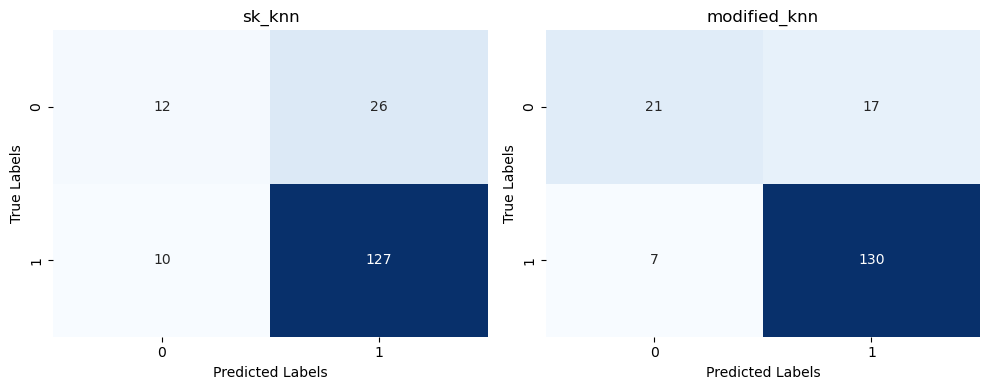

In [89]:
df = pd.read_csv('../files_csv/csv_tests/dataset_9971.csv')

y_pred_sk, y_pred_mod, y_test = instantiate_model(df, seed=11)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_confusion_matrix(y_test, y_pred_sk, ax=axes[0])
axes[0].set_title("sk_knn")

plot_confusion_matrix(y_test, y_pred_mod, ax=axes[1])
axes[1].set_title("modified_knn")

plt.tight_layout()
plt.show()

    

### Dataset 10101

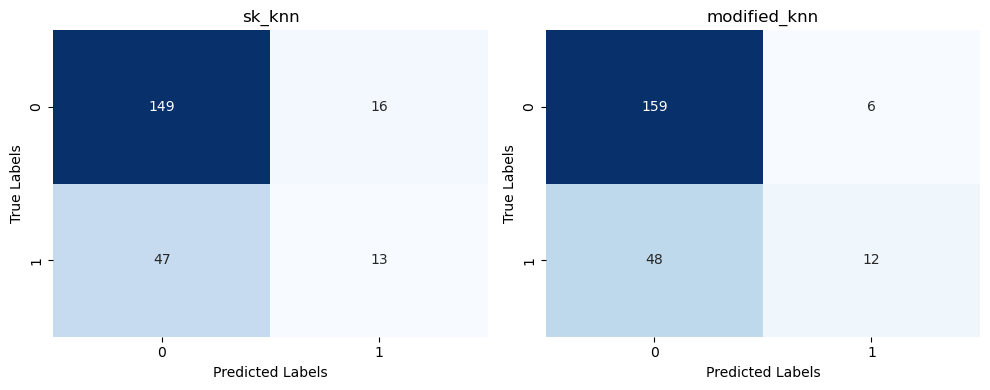

In [60]:
df = pd.read_csv('../files_csv/csv_tests/dataset_10101.csv')

y_pred_sk, y_pred_mod, y_test = instantiate_model(df, seed=2)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_confusion_matrix(y_test, y_pred_sk, ax=axes[0])
axes[0].set_title("sk_knn")

plot_confusion_matrix(y_test, y_pred_mod, ax=axes[1])
axes[1].set_title("modified_knn")

plt.tight_layout()
plt.show()


### Dataset 31

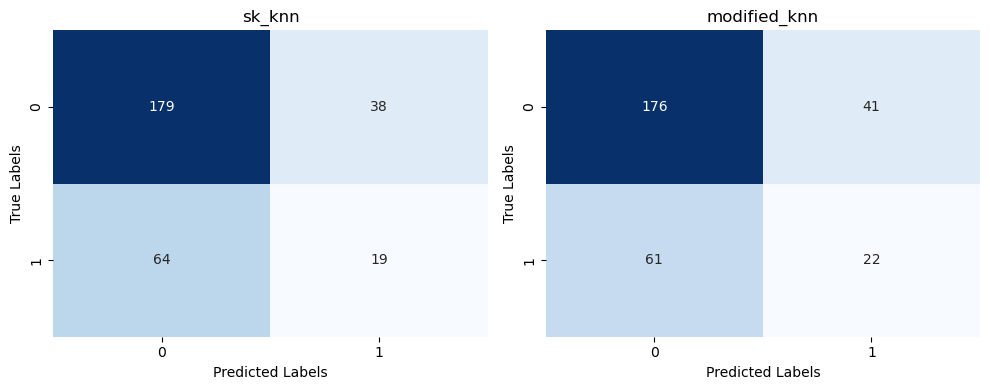

In [85]:
df = pd.read_csv('../files_csv/csv_tests/dataset_31.csv')

for column in categorical_columns:
    df[column], _ = pd.factorize(df[column])
    
y_pred_sk, y_pred_mod, y_test = instantiate_model(df, seed=7)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_confusion_matrix(y_test, y_pred_sk, ax=axes[0])
axes[0].set_title("sk_knn")

plot_confusion_matrix(y_test, y_pred_mod, ax=axes[1])
axes[1].set_title("modified_knn")

plt.tight_layout()
plt.show()
